In [3]:
#IMPORT LIBRARIES 
import numpy as np
import cv2
import tensorflow as tf
import tensorflow
import os
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm_notebook

import keras
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


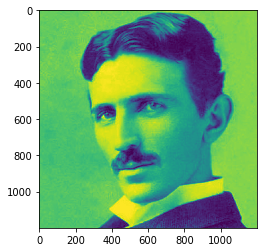

In [4]:
maxdim = 300
image_size = (maxdim,maxdim)
#READ CONTENT IMAGES
content_image_path = "/home/ajax/Downloads/ML_AI/Style_trasnfer/content_1.jpg"
plt.imshow(plt.imread(content_image_path))

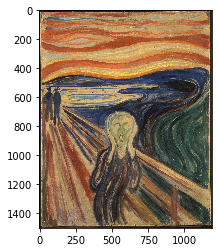

In [5]:
style_image_path = "/home/ajax/Downloads/ML_AI/Style_trasnfer/style_2.jpg"
plt.imshow(plt.imread(style_image_path))

In [6]:
#CONTENT LAYERS
content_layers = ['block5_conv2'] 
#CONTENT LAYERS
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

num_style_layers = len(style_layers) #NO. OF LAYERS USED FOR STYLE
num_content_layers = len(content_layers) #NO. OF LAYERS USED FOR CONTENT
print("No of style layers = ",num_style_layers)
print("No of content layers = ",num_content_layers)

No of style layers =  5
No of content layers =  1


In [7]:
## UNCOMENT TO DOWNLOAD NEW MODEL OF VGG16
#vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

"""
model1 = tensorflow.keras.models.load_model("vgg_new")
model1.trainable = False

content_outputs = [model1.get_layer(name).output for name in content_layers]
style_outputs = [model1.get_layer(name).output for name in style_layers]
model_outputs = style_outputs + content_outputs

m = tensorflow.keras.models.Model(model1.input,model_outputs)
"""


'\nmodel1 = tensorflow.keras.models.load_model("vgg_new")\nmodel1.trainable = False\n\ncontent_outputs = [model1.get_layer(name).output for name in content_layers]\nstyle_outputs = [model1.get_layer(name).output for name in style_layers]\nmodel_outputs = style_outputs + content_outputs\n\nm = tensorflow.keras.models.Model(model1.input,model_outputs)\n'

In [8]:
m = tensorflow.keras.models.load_model("Style_transfer_model")
m.trainable = False

In [9]:
def gram_matrix(image):
    
    channel_len = image.shape[-1] #GET CHANNELS IN IMAGE
    image = tf.reshape(image,(-1,channel_len))
    
    gram_matrix = tf.matmul(image,image ,transpose_a = True)
    gram_matrix = tf.expand_dims(gram_matrix, axis=0)
    
    return gram_matrix

In [10]:
def style_loss(style_input):
    Loss_style = 0
    for i in range(0,num_style_layers,1):

        _,h,w,c = style_input[i].shape
        img_1 = gram_matrix(style_input[i])
        img_2 = gram_matrix(target_style[i])
        Loss_style += (tf.reduce_mean(tf.math.square(img_1-img_2))/((2*w*h*c)**2))
   
    return Loss_style

In [11]:
def content_loss(image):
    
    Loss_content = tf.reduce_mean(tf.math.square(image-target_content))    

    return Loss_content

In [26]:
def total_loss(Loss_style,Loss_content,alpha= 40,beta=60):
    
    Loss_total  = tf.reduce_mean(alpha * Loss_style + beta*Loss_content)
    
    return Loss_total

In [13]:
def compute_loss(output):
    
    content_output = output[0]#LIST (LEN 1) OF CONTENT OUTPUT
    style_output = output[1:] #LIST OF STYLE OUTPUT

    Loss_style = style_loss(style_output)
    Loss_content = content_loss(content_output)

    Loss_total = total_loss(Loss_style,Loss_content)
    
    return Loss_total

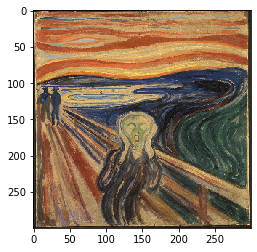

In [14]:
content_image = cv2.imread(content_image_path,1)
style_image = cv2.imread(style_image_path,1)

content_image = cv2.cvtColor(content_image,cv2.COLOR_BGR2RGB)
style_image = cv2.cvtColor(style_image,cv2.COLOR_BGR2RGB)

content_image = cv2.resize(content_image,image_size).reshape(1,maxdim,maxdim,3)
style_image = cv2.resize(style_image,image_size).reshape(1,maxdim,maxdim,3)

plt.imshow(style_image[0,::])

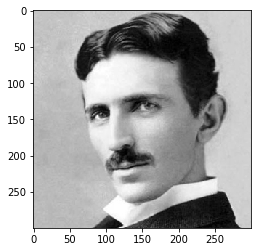

In [15]:
plt.imshow(content_image[0,::])

In [33]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
opt = tensorflow.optimizers.Adam(learning_rate=1.5)
generated_image = tf.Variable(content_image,dtype=tf.float32)

In [17]:
def normalizer(final_image):
    
    result = np.empty((300,300,3))
    for i in range(3):
        
        img_min = np.min(final_image[0,:,:,i])
        img_max = np.max(final_image[0,:,:,i])       
        result[:,:,i] = (final_image[0,:,:,i]-img_min)/(img_max-img_min)
    
    return result
        

In [18]:
target_content = m(np.clip(content_image, min_vals, max_vals))
target_style = m(np.clip(style_image, min_vals, max_vals))

target_content = target_content[0]
target_style = target_style[1:]

In [19]:
def train_step(iterations,generated_image):
    
    losses = []
    for i in tqdm_notebook(range(iterations)):
        with  tf.GradientTape() as tape:
            
            tape.watch(generated_image) #VVV IMP
            output = m(generated_image)
            
            loss = compute_loss(output)
            losses.append(loss)

            grad = tape.gradient(loss, generated_image)
            opt.apply_gradients(zip([grad], [generated_image]))
           
            # Make sure image values stays in the range of max-min value of VGG norm
            clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
            # assign the clipped value to the tensor stylized image
            generated_image.assign(clipped)
    
    generated_image = normalizer(generated_image)
    losses = np.array(losses)
    
    return losses,generated_image

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


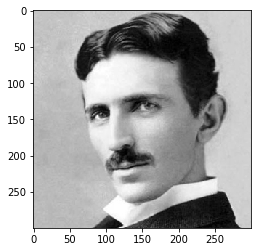

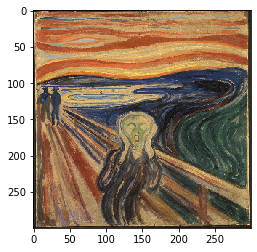

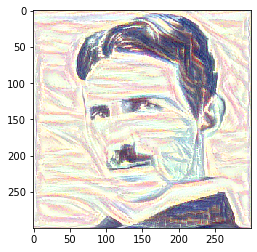

In [36]:
iterations = 100
initial_image = generated_image

losses,final_image = train_step(iterations,generated_image)

plt.imshow(content_image[0,::])
plt.show()
plt.imshow(style_image[0,::])
plt.show()
plt.imshow(final_image)
plt.show()

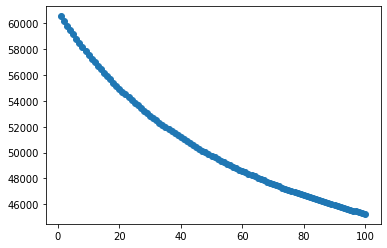

45257.29


In [37]:
x = np.arange(len(losses))+1
plt.scatter(x,losses)
plt.show()
print(losses[-1])

In [27]:
iterations = 100
losses,final_image = train_step(iterations,generated_image)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


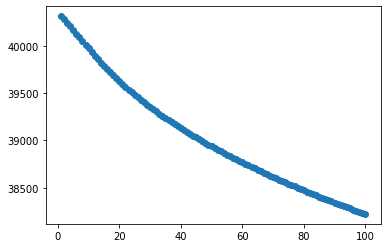

38222.305


In [28]:
x = np.arange(len(losses))+1
plt.scatter(x,losses)
plt.show()
print(losses[-1])

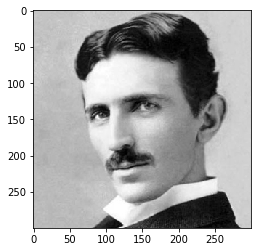

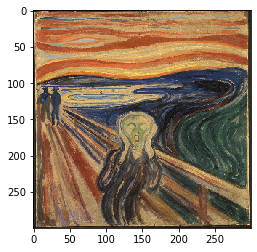

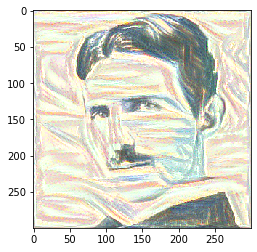

In [29]:
plt.imshow(content_image[0,::])
plt.show()
plt.imshow(style_image[0,::])
plt.show()
plt.imshow(final_image)
plt.show()

In [43]:
plt.imsave("result_2.png",final_image)